In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn import metrics, utils
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

import yaml

with open('config.yaml') as f:
    config = yaml.load(f)
    data_path = config['data_path']

/home/tangsp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  if sys.path[0] == '':


In [2]:
matplotlib.rcParams['font.size'] = 12.0
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = [
    'Roboto',
    'DejaVu Sans',
    'sans-serif'
]

In [3]:
tasks = ['ARF', 'Shock']
Ts = [4, 12]
models = ['LR', 'RF', 'CNN_V3', 'RNN_V2', ]
colors = ['#2ca02c', '#d62728', '#1f77b4', '#ff7f0e']

In [11]:
dt = 1.0
output = {}

for task in tasks:
    output[task] = {}
    for T in Ts:
        output[task][T] = {}
        for model in models:
            f = np.load(open('output/outcome={}.T={}.dt={}/{}.test.npz'.format(task, T, dt, model), 'rb'))
            y_score, y_true = f['y_score'], f['y_true']
            output[task][T][model] = (y_score, y_true)
        
        # Check all test sets are equal
        y_trues = [y_true for _, y_true in output[task][T].values()]
        assert all((e == y_trues[0]).all() for e in y_trues)

task = 'mortality'
output[task] = {}
T = 48
output[task][T] = {}
for model in models:
    f = np.load(open('output/outcome={}.T={}.dt={}/{}.test.npz'.format(task, T, dt, model), 'rb'))
    y_score, y_true = f['y_score'], f['y_true']
    output[task][T][model] = (y_score, y_true)

# Check all test sets are equal
y_trues = [y_true for _, y_true in output[task][T].values()]
assert all((e == y_trues[0]).all() for e in y_trues)

In [5]:
def plot_pred_gaps(task, T):
    f = np.load(open('output/outcome={}.T={}.dt={}/idx.npz'.format(task, T, dt), 'rb'))
    tr_idx, va_idx, te_idx = f['tr_idx'], f['va_idx'], f['te_idx']

    df_true = pd.read_csv(data_path + 'population/{}_{}h.csv'.format(task, T))
    y_true = df_true.iloc[te_idx]['{}_LABEL'.format(task)].values
    assert (y_true == output[task][T]['CNN_V3'][1].ravel().astype(int)).all()
    df_true = df_true.iloc[te_idx]

    # Prediction gap
    def func(i):
        y_true_b, y_score_b = utils.resample(y_truex, y_scorex, replace=True, random_state=i)
        return metrics.roc_auc_score(y_true_b, y_score_b)

    scores = [[], [] ,[], []]
    score_stds = [[], [], [], []]
    for x in tqdm(range(0, 13)):
        mask = ~(df_true['{}_ONSET_HOUR'.format(task)] < T + x)
        y_gapx = df_true[mask][['ICUSTAY_ID', '{}_LABEL'.format(task)]].reset_index(drop=True)
        for i, model in enumerate(models):
#         for i, y_score in enumerate([
#             output[task][T]['CNN_V3'][0],
#             output[task][T]['RNN_V2'][0],
#             output[task][T]['LR'][0],
#             output[task][T]['RF'][0]
#         ]):
            y_score = output[task][T][model][0]
    #         df_gapx = df[df['ICUSTAY_ID'].isin(y_gapx['ICUSTAY_ID'])].reset_index(drop=True)
            y_truex = y_gapx['{}_LABEL'.format(task)].values
    #         y_score = df_gapx['y_score'].values
            y_scorex = y_score[mask]
            scores[i].append(metrics.roc_auc_score(y_truex, y_scorex))

            boot_scores = Parallel(n_jobs=1)(delayed(func)(j) for j in range(1000))

            score_stds[i].append(np.std(boot_scores))
    #         np.percentile(test_scores, 2.5), np.percentile(test_scores, 97.5)

    fig, ax = plt.subplots(figsize=(5,3))
    # x = np.arange(4, 29) - 4
    y = np.array(scores).T
    err = np.array(score_stds).T

    # plt.plot(x, y, marker='.', linestyle='')
    # # plt.fill_between(x, (y-err), (y+err), alpha=0.15)
    # plt.fill_between(x, (y-err)[:,0], (y+err)[:,0], alpha=0.15)
    # plt.fill_between(x, (y-err)[:,1], (y+err)[:,1], alpha=0.15)
    # plt.fill_between(x, (y-err)[:,2], (y+err)[:,2], alpha=0.15)
    # plt.fill_between(x, (y-err)[:,3], (y+err)[:,3], alpha=0.15)

    for color, x, y, yerr, x_offset in zip(
        colors,
        [np.arange(0, 13, 1)] * 4,
        [np.array(scores)[0, ::1].T, np.array(scores)[1, ::1].T, np.array(scores)[2, ::1].T, np.array(scores)[3, ::1].T],
        [np.array(score_stds)[0, ::1].T, np.array(score_stds)[1, ::1].T, np.array(score_stds)[2, ::1].T, np.array(score_stds)[3, ::1].T],
        np.array([-1.5, -0.5, 0.5, 1.5]) * 0.15,
    ):
        plt.plot(x+x_offset, y, '.', color=color, markersize=8, label=model)
        markers, caps, bars = plt.errorbar(x+x_offset, y, yerr=yerr, fmt='.', color=color, markersize=0, capsize=0.0, elinewidth=1.5)
        [bar.set_alpha(0.75) for bar in bars]
        [cap.set_alpha(0.75) for cap in caps]

    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    plt.grid(axis='y', color='gray', linestyle=':')
    plt.ylim(0.65, 0.90)

    plt.ylabel('Test AUROC (±SE)')
    plt.xlabel('Prediction Gap since {}h (h)'.format(T))
    plt.legend(
        ['LR', 'RF', 'CNN', 'RNN'], 
        ncol=2, 
        loc='upper right',
        handlelength=0.5,
#         fontsize=10.0,
    )
    plt.xticks(np.arange(0, 13, 1))
    plt.title(task)
    plt.tight_layout()
    plt.savefig('figures/PredGap-{}_{}.svg'.format(task, T))

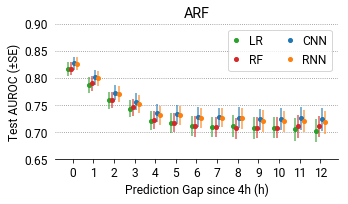

In [6]:
plot_pred_gaps(task = 'ARF', T = 4)

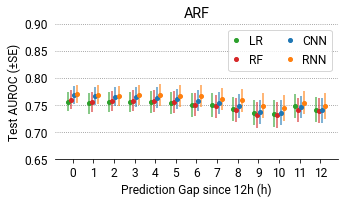

In [8]:
plot_pred_gaps(task = 'ARF', T = 12)

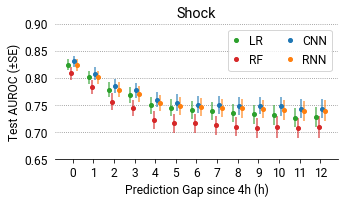

In [9]:
plot_pred_gaps(task = 'Shock', T = 4)

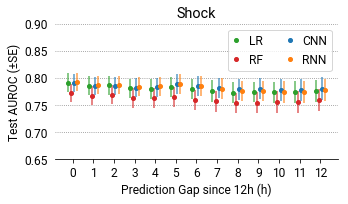

In [10]:
plot_pred_gaps(task = 'Shock', T = 12)

In [4]:
def bootstrap_func(i, y_true, y_score):
    yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
    return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)

In [13]:
task = 'Shock'
dt = 1.0
T1 = 4
T2 = 12

In [6]:
f = np.load(open('output/outcome={}.T={}.dt={}/idx.npz'.format(task, T1, dt), 'rb'))
tr_idx, va_idx, te_idx = f['tr_idx'], f['va_idx'], f['te_idx']
df_true = pd.read_csv(data_path + 'population/{}_{}h.csv'.format(task, T1))
IDs = df_true.loc[te_idx, 'ICUSTAY_ID'].reset_index(drop=True)

In [7]:
f = np.load(open('output/outcome={}.T={}.dt={}/idx.npz'.format(task, T2, dt), 'rb'))
tr_idx, va_idx, te_idx = f['tr_idx'], f['va_idx'], f['te_idx']
df_true = pd.read_csv(data_path + 'population/{}_{}h.csv'.format(task, T2))

In [8]:
mask = [pd.Index(IDs).get_loc(i) for i in df_true.loc[te_idx, 'ICUSTAY_ID']]

In [14]:
output[task][T1][model][1].mean(), output[task][T2][model][1].mean(), 

(0.14684339, 0.07886677)

In [18]:
true_auc_scores1 = []
true_auc_scores2 = []
for model in models:
    print(model)
    y_score, y_true = output[task][T1][model]
    score1 = metrics.roc_auc_score(y_true[mask], y_score[mask])
    true_auc_scores1.append(score1)
    roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true[mask], y_score[mask]) for i in range(1000)))
    auc_scores1 = auc_scores
    print(T1, score1)
    print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true[mask], y_score[mask])))
    print('Test AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
    y_score, y_true = output[task][T2][model]
    score2 = metrics.roc_auc_score(y_true, y_score)
    true_auc_scores2.append(score2)
    roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score) for i in range(1000)))
    auc_scores2 = auc_scores
    print(T2, score2)
    print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true, y_score)))
    print('Test AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
    
    print(
        'one-sided p-value:', 
        2 * min(
            (auc_scores1 < auc_scores2).mean(),
            (auc_scores1 > auc_scores2).mean(),
        )
    )

LR
4 0.736201567279213
Test AUC: 0.736
Test AUC: (0.704, 0.770) percentile 95% CI
12 0.7916495169842385
Test AUC: 0.792
Test AUC: (0.758, 0.824) percentile 95% CI
one-sided p-value: 0.0
RF
4 0.7108180196757298
Test AUC: 0.711
Test AUC: (0.675, 0.747) percentile 95% CI
12 0.7725568764173709
Test AUC: 0.773
Test AUC: (0.740, 0.806) percentile 95% CI
one-sided p-value: 0.0
CNN_V3
4 0.7493745409937939
Test AUC: 0.749
Test AUC: (0.717, 0.781) percentile 95% CI
12 0.791377139675084
Test AUC: 0.791
Test AUC: (0.758, 0.823) percentile 95% CI
one-sided p-value: 0.0
RNN_V2
4 0.7444999959647804
Test AUC: 0.744
Test AUC: (0.711, 0.776) percentile 95% CI
12 0.7919360175612749
Test AUC: 0.792
Test AUC: (0.759, 0.823) percentile 95% CI
one-sided p-value: 0.0


In [38]:
task = 'ARF'
dt = 1.0
T1 = 4
T2 = 12

In [39]:
f = np.load(open('output/outcome={}.T={}.dt={}/idx.npz'.format(task, T1, dt), 'rb'))
tr_idx, va_idx, te_idx = f['tr_idx'], f['va_idx'], f['te_idx']
df_true = pd.read_csv(data_path + 'population/{}_{}h.csv'.format(task, T1))
IDs = df_true.loc[te_idx, 'ICUSTAY_ID'].reset_index(drop=True)

In [40]:
f = np.load(open('output/outcome={}.T={}.dt={}/idx.npz'.format(task, T2, dt), 'rb'))
tr_idx, va_idx, te_idx = f['tr_idx'], f['va_idx'], f['te_idx']
df_true = pd.read_csv(data_path + 'population/{}_{}h.csv'.format(task, T2))

In [41]:
mask = [pd.Index(IDs).get_loc(i) for i in df_true.loc[te_idx, 'ICUSTAY_ID']]

In [42]:
output[task][T1][model][1].mean(), output[task][T2][model][1].mean(), 

(0.18659881, 0.0960344)

In [43]:
true_auc_scores1 = []
true_auc_scores2 = []
for model in models:
    print(model)
    y_score, y_true = output[task][T1][model]
    score1 = metrics.roc_auc_score(y_true[mask], y_score[mask])
    true_auc_scores1.append(score1)
    roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true[mask], y_score[mask]) for i in range(1000)))
    print(T1, score1)
    print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true[mask], y_score[mask])))
    print('Test AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
    
    y_score, y_true = output[task][T2][model]
    score2 = metrics.roc_auc_score(y_true, y_score)
    true_auc_scores2.append(score2)
    roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score) for i in range(1000)))
    print(T2, score2)
    print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true, y_score)))
    print('Test AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))

LR
4 0.7123131698799869
Test AUC: 0.712
Test AUC: (0.674, 0.746) percentile 95% CI
12 0.7565213046816657
Test AUC: 0.757
Test AUC: (0.720, 0.789) percentile 95% CI
RF
4 0.7083215003208061
Test AUC: 0.708
Test AUC: (0.671, 0.743) percentile 95% CI
12 0.7600869857898669
Test AUC: 0.760
Test AUC: (0.726, 0.793) percentile 95% CI
CNN_V3
4 0.7279248577408939
Test AUC: 0.728
Test AUC: (0.690, 0.762) percentile 95% CI
12 0.7682175801752338
Test AUC: 0.768
Test AUC: (0.733, 0.800) percentile 95% CI
RNN_V2
4 0.7265285622626824
Test AUC: 0.727
Test AUC: (0.689, 0.762) percentile 95% CI
12 0.7709365434981541
Test AUC: 0.771
Test AUC: (0.737, 0.802) percentile 95% CI
